<a href="https://colab.research.google.com/github/rosehunnie/NLP/blob/main/classificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('/content/sample_data/Leads.csv')
df.head()


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [2]:
target = 'Converted'

categorical = [
    'Lead Origin',
    'Lead Source',
    'Do Not Email',
    'Do Not Call',
    'Last Activity',
    'Country',
    'Specialization',
    'How did you hear about X Education',
    'What is your current occupation',
    'What matters most to you in choosing a course',
    'Tags'
]

numerical = [
    'TotalVisits',
    'Total Time Spent on Website',
    'Page Views Per Visit',
    'Asymmetrique Activity Index',
    'Asymmetrique Profile Index',
    'Asymmetrique Activity Score',
    'Asymmetrique Profile Score'
]


In [3]:
df = df.copy()

df[categorical] = df[categorical].fillna('missing')

for col in numerical:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[numerical] = df[numerical].fillna(df[numerical].mean())


In [4]:
from sklearn.model_selection import train_test_split

X = df[categorical + numerical]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [5]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
X_train_dict = X_train.to_dict(orient='records')
X_train_vectorized = dv.fit_transform(X_train_dict)


In [6]:
import numpy as np

X_train_vectorized = np.nan_to_num(X_train_vectorized)


In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train_vectorized, y_train)


LogisticRegression(random_state=1, solver='liblinear')

In [8]:
# Clean X_test
X_test = X_test.copy()
X_test[categorical] = X_test[categorical].fillna('missing')
for col in numerical:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
X_test[numerical] = X_test[numerical].fillna(X_test[numerical].mean())

# Vectorize
X_test_dict = X_test.to_dict(orient='records')
X_test_vectorized = dv.transform(X_test_dict)
X_test_vectorized = np.nan_to_num(X_test_vectorized)

# Predict
y_pred = model.predict(X_test_vectorized)
y_probs = model.predict_proba(X_test_vectorized)[:, 1]


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


Accuracy: 0.9426406926406926

Confusion Matrix:
 [[1078   41]
 [  65  664]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1119
           1       0.94      0.91      0.93       729

    accuracy                           0.94      1848
   macro avg       0.94      0.94      0.94      1848
weighted avg       0.94      0.94      0.94      1848



In [10]:
feature_names = dv.get_feature_names_out()
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
feature_importance_sorted = feature_importance.sort_values(by='AbsCoefficient', ascending=False)


<ipython-input-11-606b80088a96>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_sorted.head(10), x='AbsCoefficient', y='Feature', palette='viridis')


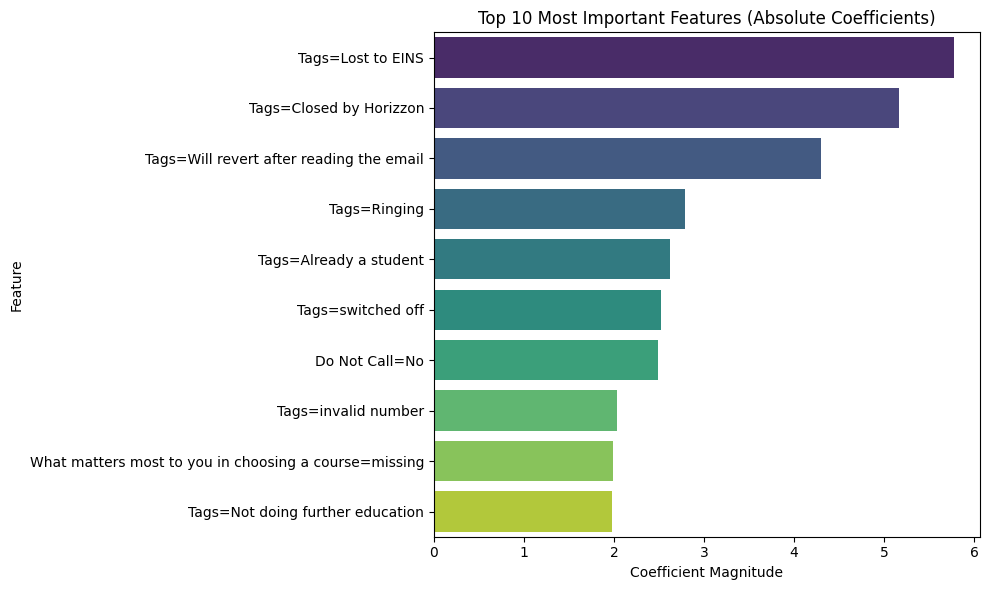

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_sorted.head(10), x='AbsCoefficient', y='Feature', palette='viridis')
plt.title("Top 10 Most Important Features (Absolute Coefficients)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
